<a href="https://colab.research.google.com/github/soroushmirzaei/text-processing-projects/blob/main/go-emotions-text-classification/go-emotions-text-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import requirement libraries
import os
import shutil

#import dataset query libraries
import csv
import json

#import mathematics statics libraries
import random as rnd
import numpy as np
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning deep learning libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras


In [ ]:
#download stop-words dataset
!wget -q https://raw.githubusercontent.com/soroushmirzaei/text-processing-projects/main/english-language-stop-words.txt
!wget -q https://raw.githubusercontent.com/soroushmirzaei/text-processing-projects/main/persian-language-stop-words.txt

#download filters-characters dataset
!wget -q https://raw.githubusercontent.com/soroushmirzaei/text-processing-projects/main/english-language-filter-characters.txt
!wget -q https://raw.githubusercontent.com/soroushmirzaei/text-processing-projects/main/persian-language-filter-characters.txt

#download similar-characters dataset
!wget -q https://raw.githubusercontent.com/soroushmirzaei/text-processing-projects/main/persian-language-similar-characters.json


In [ ]:
#define filters-list function loader
def filter_chars(file_path):
    filter_chars = list()
    with open(file_path, 'r') as filters_list_file:
        for word in filters_list_file:
            filter_chars.append(word.strip('\n'))
        filters_list_file.close()
    return filter_chars

#define stop-words function loader
def stop_word(file_path):
    stop_words = list()
    with open(file_path, 'r') as stop_words_file:
        for word in stop_words_file:
            stop_words.append(word.strip('\n'))
        stop_words_file.close()
    return stop_words

#define similar-characters function loader
def similar_chars(file_path):
    with open(file_path, 'r') as similar_chars_file:
        similar_chars = json.load(similar_chars_file)
    return similar_chars


In [ ]:
#load stop-words
eng_stop_words = stop_word('english-language-stop-words.txt')
per_stop_words = stop_word('persian-language-stop-words.txt')

#load filters-characters
eng_filter_characters = filter_chars('english-language-filter-characters.txt')
per_filter_characters = filter_chars('persian-language-filter-characters.txt')

#load similar-characters
per_similar_characters = similar_chars('persian-language-similar-characters.json')


In [ ]:
#define remove filters characters function
def remove_filter(text, filters_list):
    characters = list(text)
    characters_without_filters = [character for character in characters if character not in filters_list]
    text_without_filters = ''.join(characters_without_filters)
    return text_without_filters

#define remove texts stopwords function
def remove_stopword(text, stop_words_list):
    text = text.lower()
    words_with_stopwords = text.split(' ')
    words_without_stopwords = [word for word in words_with_stopwords if word not in stop_words_list]
    text_without_stopwords = ' '.join(words_without_stopwords)
    return text_without_stopwords

#define similar characters modification function
def similar_char(text, similar_chars_dict):
    characters = list(text)
    similar_characters_modified_list = [similar_chars_dict.get(character,character) for character in characters]
    similar_characters_modified_text = ''.join(similar_characters_modified_list)
    return similar_characters_modified_text


In [ ]:
#load dataset
data, info = tfds.load('goemotions', with_info = True)


In [ ]:
#print out dataset info
info


tfds.core.DatasetInfo(
    name='goemotions',
    version=0.1.0,
    description='The GoEmotions dataset contains 58k carefully curated Reddit comments labeled
for 27 emotion categories or Neutral. The emotion categories are admiration,
amusement, anger, annoyance, approval, caring, confusion, curiosity, desire,
disappointment, disapproval, disgust, embarrassment, excitement, fear,
gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief,
remorse, sadness, surprise.',
    homepage='https://github.com/google-research/google-research/tree/master/goemotions',
    features=FeaturesDict({
        'admiration': tf.bool,
        'amusement': tf.bool,
        'anger': tf.bool,
        'annoyance': tf.bool,
        'approval': tf.bool,
        'caring': tf.bool,
        'comment_text': Text(shape=(), dtype=tf.string),
        'confusion': tf.bool,
        'curiosity': tf.bool,
        'desire': tf.bool,
        'disappointment': tf.bool,
        'disapproval': tf.bool,
   

In [ ]:
#define tensorflow text labels loader
def tfds_texts_labels_lodaer(#define data and keyword
                             data, key,
                             ):
    
    #define empty texts labels list
    texts_list = list()
    labels_list = list()

    #iterate over data by key to split texts labels
    for item in data[key]:
        texts_list.append(item['comment_text'].numpy().decode('utf8'))
        emotion_list = list()
        for emotion_key in item.keys():
            if item[emotion_key].numpy() == True:
                emotion_list.append(emotion_key)
        labels_list.append(emotion_list)
            

    return texts_list, labels_list


In [ ]:
train_texts_list, train_labels_list = tfds_texts_labels_lodaer(data, 'train')
valid_texts_list, valid_labels_list = tfds_texts_labels_lodaer(data, 'test')


In [ ]:
train_texts_list[:5]

["It's just wholesome content, from questionable sources",
 'This is actually awesome.',
 "People really spend more than $10 in an app game? I mean an actual video game I can understand but that's just...sad",
 'I grew up on the other side of Ama but live in Tulia now. I will have some El Burrito for you',
 'What the problem? I mean, steak? Good. Doughnuts? Good!! I don’t see an issue. ']

In [ ]:
train_labels_list[:5]

[['neutral'],
 ['admiration'],
 ['confusion', 'sadness'],
 ['neutral'],
 ['curiosity', 'disapproval']]

In [ ]:
#define labels encoder
def label_encoder(#define labels list and method
                  labels_list,
                  #define method binary, ordinal or onehot
                  method, return_categories = True
                  ):

    total_labels = list()

    #one-hot encoder method
    if method in ['onehot']:
        for label_list in labels_list:
            for label in label_list:
                total_labels.append(label)

        unique_labels = sorted(list(set(total_labels)))
        labels_dict = {
            label : int(unique_labels.index(label)) for label in unique_labels
        }

        labels_encoded = list()
        for label_list in labels_list:
            label_encoded = len(unique_labels)*[0]
            for label in label_list:
                label_number = labels_dict[label]
                label_encoded[label_number] = int(1)
            label_encoded = [label / sum(label_encoded) for label in label_encoded]
            labels_encoded.append(label_encoded)
        
        labels = labels_encoded

    #convert list type to array
    labels_encoded = np.array(labels)
    
    if return_categories:
        return labels_encoded, labels_dict
    else:
        return labels_encoded
        

In [ ]:
train_labels_encoded, train_labels_dict = label_encoder(train_labels_list, 'onehot')
valid_labels_encoded, valid_labels_dict = label_encoder(valid_labels_list, 'onehot')


In [ ]:
train_labels_dict

{'admiration': 0,
 'amusement': 1,
 'anger': 2,
 'annoyance': 3,
 'approval': 4,
 'caring': 5,
 'confusion': 6,
 'curiosity': 7,
 'desire': 8,
 'disappointment': 9,
 'disapproval': 10,
 'disgust': 11,
 'embarrassment': 12,
 'excitement': 13,
 'fear': 14,
 'gratitude': 15,
 'grief': 16,
 'joy': 17,
 'love': 18,
 'nervousness': 19,
 'neutral': 20,
 'optimism': 21,
 'pride': 22,
 'realization': 23,
 'relief': 24,
 'remorse': 25,
 'sadness': 26,
 'surprise': 27}

In [ ]:
train_labels_encoded[:5]

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0.5, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0.5, 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ]])

In [ ]:
#define tokenizer and sequences and padding sequences
def pad_sequences(#define training and validation set
                  train_texts, valid_texts,
                  #define vocab size and out of vocab word
                  vocab_size = None, oov_word = None,
                  #define filter characters list
                  use_modified_filters = False, filters_list = None,
                  #define sequence length, padding and truncating
                  sequence_len = None, padding_point = 'post', truncating_point = 'post',
                  #define json tokenizer
                  save_tokenizer_json = False, tokenizer_filepath = None
                  ):
    
    #define tokenizer and fit
    from keras.preprocessing.text import Tokenizer
    if use_modified_filters:
        filters = ''.join(filters_list)
    else:
        filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_word,
                          filters = filters)
    tokenizer.fit_on_texts(train_texts)
    word_index = tokenizer.word_index

    if save_tokenizer_json:
        with open(tokenizer_filepath+'.json','w') as tokenizer_file:
            json.dump(tokenizer.to_json(), tokenizer_file)

    #define training validation texts to sequences
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    valid_sequences = tokenizer.texts_to_sequences(valid_texts)

    #define training validation pad sequences
    from keras.preprocessing.sequence import pad_sequences
    train_padded_sequences = pad_sequences(train_sequences, maxlen = sequence_len,
                                           padding = padding_point, truncating = truncating_point)
    valid_padded_sequences = pad_sequences(valid_sequences, maxlen = sequence_len,
                                           padding = padding_point, truncating = truncating_point)

    return train_padded_sequences, valid_padded_sequences, tokenizer, word_index


In [ ]:
train_padded_sequences, valid_padded_sequences, tokenizer, word_index = pad_sequences(#define training and validation set
                                                                                      train_texts_list, valid_texts_list,
                                                                                      #define vocab size and out of vocab word
                                                                                      vocab_size = None, oov_word = '<oov>',
                                                                                      #define filter characters list
                                                                                      use_modified_filters = False, filters_list = None,
                                                                                      #define sequence length, padding and truncating
                                                                                      sequence_len = 150)

In [ ]:
#load pre-trained word vectors
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

#unzip the loaded file
!unzip -q crawl-300d-2M.vec.zip


--2022-07-11 17:26:21--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  17.2MB/s    in 95s     

2022-07-11 17:27:57 (15.3 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [ ]:
#define pre-trained words dictionary loader
def word_dict_loader(#define file path and file type
                     file_path, file_type,
                     #define txt and csv file type args
                     word_index = None, vector_index = None, header = True, spliter_delimiter = None,
                     use_word_spliter = False, word_spliter = None, word_split_index = None,
                     #define json file type args
                     word_key = None, vector_key = None,
                     ):
    
    word_dict = dict()

    #define txt vec loader
    if file_type in ['txt', 'vec']:
        with open(file_path, 'r') as word_dict_file:
            if header:
                next(word_dict_file)
            for row in word_dict_file:
                row = row.split(spliter_delimiter)
                if use_word_spliter:
                    word = row[word_index].split(word_spliter)[word_split_index]
                else:
                    word = row[word_index]
                vectors = np.array(row[vector_index:], dtype = 'float32')
                word_dict[word] = vectors

    #define csv loader
    elif file_type in ['csv']:
        with open(file_path, 'r') as word_dict_file:
            word_dict_file = csv.reader(word_dict_file, delimiter = spliter_delimiter)
            if header:
                next(word_dict_file)
            for row in word_dict_file:
                if use_word_spliter:
                    word = row[word_index].split(word_spliter)[word_split_index]
                else:
                    word = row[word_index]
                vectors = np.array(row[vector_index:], dtype = 'float32')
                word_dict[word] = vectors
                
    #define json loader
    elif file_type in ['json']:
        with open(file_path, 'r') as word_dict_file:
            word_dict_file = json.load(word_dict_file)
            for item in word_dict_file:
                word = item[word_key]
                vectors = np.array(item[vector_key], dtype = 'float32')
                word_dict[word] = vectors

    #word dict params
    word_dict_size = len(word_dict)
    word_dict_dim = list(word_dict.values())[0].shape[0]

    return word_dict, word_dict_size, word_dict_dim


In [ ]:
word_dict, word_dict_size, word_dict_dim = word_dict_loader(#define file path and file type
                                                            file_path = '/content/crawl-300d-2M.vec', file_type = 'vec',
                                                            #define txt and csv file type args
                                                            word_index = 0, vector_index = 1, header = True, spliter_delimiter = ' ')


In [ ]:
#define pre-trained embedding word vectors
def embd_weights_loader(#define word dictionary and word index
                        word_dict, word_index, dimension
                        ):
    
    #create embedding weights
    embed_weights = np.zeros([len(word_index)+1, dimension], dtype = 'float32')

    counter = 0
    for word, index in word_index.items():
        if word in word_dict:
            embed_weights[index] = word_dict[word]
            counter += 1

    #embedding layer params
    vocab_size = embed_weights.shape[0]
    embed_dim = embed_weights.shape[1]

    return embed_weights, vocab_size, embed_dim, counter


In [ ]:
embed_weights, vocab_size, embed_dim, counter = embd_weights_loader(#define word dictionary and word index
                                                                    word_dict = word_dict, word_index = word_index,
                                                                    dimension = word_dict_dim)


In [ ]:
#define how many words the pre-trained will cover
print(f'the tokenizer word index derive {len(word_index)} words\nthe pre-traind word vectors covers {counter} words'.title())


The Tokenizer Word Index Derive 28208 Words
The Pre-Traind Word Vectors Covers 24323 Words


In [ ]:
#define model
def create_model(#define input shape
                 input_shape = None,
                 #define embedding layer parameters
                 use_pretraind_embd = False, vocab_size = None, embd_dim = None,
                 sequence_len = None, embed_weights = None,
                 #define type of layer and parameters
                 use_lstm = False, use_gru = False, use_conv = False,
                 #define lstm layers parameters
                 lstm_layers_num = None, lstm_layers_units = None,
                 #define gru layers parameters
                 gru_layers_num = None, gru_layers_units = None,
                 #define convolution layers parameters
                 conv_layers_num = None, conv_layers_filters = None, conv_layers_kernel = None,
                 #define convolution layers sub layers
                 use_max_pool = False, max_pool_size = None,
                 #define dense layer feeder
                 use_global_max_pool = False, use_global_avg_pool = False, use_flatten = False,
                 use_feeder_dropout = False, feeder_dropout_ratio = None,
                 #define dense head layers
                 use_dense_layers = True, dense_layers_num = None, dense_layers_units = None,
                 #define dense layers dropout parameters
                 use_dense_dropout = False, dense_dropout_ratio = None,
                 #define output layer parameters
                 output_layer_unit = None, output_layer_activation = None,
                 #define model compiler parameters
                 optimizer = None, loss = None, metrics = None
                 ):
    
    #define input layer
    input = keras.Input(shape = input_shape)

    #define embedding layer and parameters
    if use_pretraind_embd:
        out = keras.layers.Embedding(input_dim = vocab_size, output_dim = embd_dim, input_length = sequence_len,
                                     weights = [embed_weights], trainable = False)(input)
    else:
        out = keras.layers.Embedding(input_dim = vocab_size, output_dim = embd_dim, input_length = sequence_len)(input)

    #define type of layer and parameters
    #lstm type layers
    if use_lstm:
        sequence_return = (lstm_layers_num - 1)*[True]
        sequence_return.append(False)
        for layer_num in range(lstm_layers_num):
            out = keras.layers.Bidirectional(keras.layers.LSTM(lstm_layers_units[layer_num],
                                                               return_sequences = sequence_return[layer_num]))(out)

    #gru type layers
    elif use_gru:
        sequence_return = (gru_layers_num - 1)*[True]
        sequence_return.append(False)
        for layer_num in range(gru_layers_num):
            out = keras.layers.Bidirectional(keras.layers.GRU(gru_layers_units[layer_num],
                                                              return_sequences = sequence_return[layer_num]))(out)
    
    #convolution type layer
    elif use_conv:
        for layer_num in range(conv_layers_num):
            out = keras.layers.Conv1D(filters = conv_layers_filters[layer_num], kernel_size = conv_layers_kernel[layer_num],
                                      activation = 'relu')(out)
            if use_max_pool[layer_num]:
                out = keras.layers.MaxPool1D(max_pool_size[layer_num])(out)


    #dense layers feeder layer
    #global max pool type layer
    if use_global_max_pool:
        out = keras.layers.GlobalMaxPooling1D()(out)
        
    #global average pool type layer
    elif use_global_avg_pool:
        out = keras.layers.GlobalAveragePooling1D()(out)

    #flatten type layer
    elif use_flatten:
        out = keras.layers.Flatten()(out)

    #define feeder dropout layer
    if use_feeder_dropout:
        out = keras.layers.Dropout(feeder_dropout_ratio)(out)


    #define dense head layers
    if use_dense_layers:
        for layer_num in range(dense_layers_num):
            out = keras.layers.Dense(dense_layers_units[layer_num], activation = 'relu')(out)
            if use_dense_dropout[layer_num]:
                out = keras.layers.Dropout(dense_dropout_ratio[layer_num])(out)
    
    #define output layer
    output = keras.layers.Dense(output_layer_unit, activation = output_layer_activation)(out)

    #define model
    model = keras.models.Model(inputs = input, outputs = output)


    #compile model
    model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = metrics)
    
    return model
    

In [ ]:
#create model
model = create_model(#define input shape
                     input_shape = 150,
                     #define embedding layer parameters
                     use_pretraind_embd = True, vocab_size = vocab_size, embd_dim = embed_dim,
                     sequence_len = 150, embed_weights = embed_weights,
                     #define type of layer and parameters
                     use_lstm = False, use_gru = True, use_conv = False,
                     #define lstm layers parameters
                     lstm_layers_num = None, lstm_layers_units = None,
                     #define gru layers parameters
                     gru_layers_num = 2, gru_layers_units = [32, 32],
                     #define convolution layers parameters
                     conv_layers_num = None, conv_layers_filters = None, conv_layers_kernel = None,
                     #define convolution layers sub layers
                     use_max_pool = False, max_pool_size = None,
                     #define dense layer feeder
                     use_global_max_pool = False, use_global_avg_pool = False, use_flatten = False,
                     use_feeder_dropout = True, feeder_dropout_ratio = 0.3,
                     #define dense head layers
                     use_dense_layers = True, dense_layers_num = 2, dense_layers_units = [64, 64],
                     #define dense layers dropout parameters
                     use_dense_dropout = [True, True], dense_dropout_ratio = [0.3, 0.3],
                     #define output layer parameters
                     output_layer_unit = len(train_labels_dict), output_layer_activation = 'softmax',
                     #define model compiler parameters
                     optimizer = keras.optimizers.RMSprop(0.01), loss = 'categorical_crossentropy', metrics = 'accuracy'
                     )

In [ ]:
#model summary
model.summary(120)


Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 input_1 (InputLayer)                                 [(None, 150)]                                   0                 
                                                                                                                        
 embedding (Embedding)                                (None, 150, 300)                                8462700           
                                                                                                                        
 bidirectional (Bidirectional)                        (None, 150, 64)                                 64128             
                                                                                                                        
 bidirectional_1 

In [ ]:
#fit model
model.fit(train_padded_sequences, train_labels_encoded, epochs = 200,
          validation_data = (valid_padded_sequences, valid_labels_encoded), 
          callbacks = [keras.callbacks.EarlyStopping('val_loss', patience = 10, restore_best_weights = True),
                       keras.callbacks.ReduceLROnPlateau('val_loss', factor = 0.1, patience = 2)])


Epoch 1/200
1357/1357 [==============================] - 42s 27ms/step - loss: 2.3059 - accuracy: 0.4067 - val_loss: 2.1821 - val_accuracy: 0.4444 - lr: 0.0100
Epoch 2/200
1357/1357 [==============================] - 35s 25ms/step - loss: 2.2195 - accuracy: 0.4247 - val_loss: 2.0578 - val_accuracy: 0.4461 - lr: 0.0100
Epoch 3/200
1357/1357 [==============================] - 35s 25ms/step - loss: 2.2375 - accuracy: 0.4202 - val_loss: 2.0991 - val_accuracy: 0.4378 - lr: 0.0100
Epoch 4/200
1357/1357 [==============================] - 37s 27ms/step - loss: 2.2547 - accuracy: 0.4158 - val_loss: 2.0846 - val_accuracy: 0.4349 - lr: 0.0100
Epoch 5/200
1357/1357 [==============================] - 35s 26ms/step - loss: 2.1612 - accuracy: 0.4361 - val_loss: 2.0024 - val_accuracy: 0.4645 - lr: 1.0000e-03
Epoch 6/200
1357/1357 [==============================] - 35s 26ms/step - loss: 2.0990 - accuracy: 0.4453 - val_loss: 1.9765 - val_accuracy: 0.4647 - lr: 1.0000e-03
Epoch 7/200
1357/1357 [=========

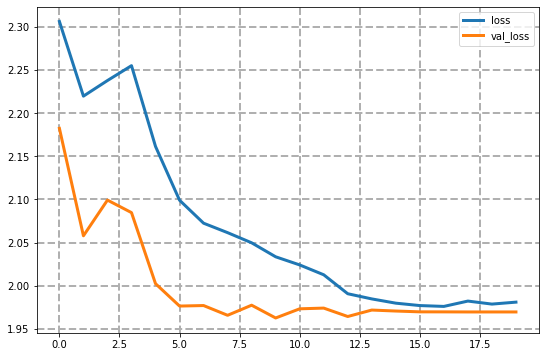

In [ ]:
#plot model training loss
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.show()


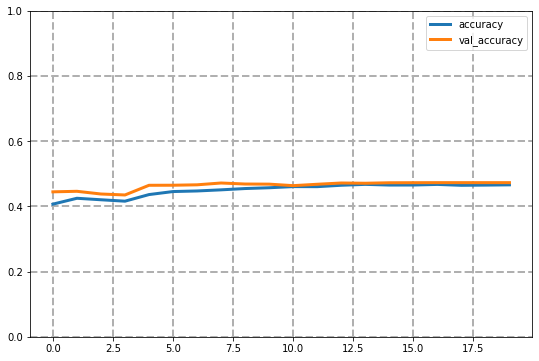

In [ ]:
#plot model training accuracy
pd.DataFrame(model.history.history)[['accuracy', 'val_accuracy']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.ylim(0,1)
plt.show()


In [ ]:
#model evaluation
train_set_eval = model.evaluate(train_padded_sequences, train_labels_encoded, verbose = 0)
valid_set_eval = model.evaluate(valid_padded_sequences, valid_labels_encoded, verbose = 0)

print(f'Training Set Evaluation:\n\tLoss: {round(train_set_eval[0],4)}\tAccuracy: {100*round(train_set_eval[1],2)}%')
print(f'Training Set Evaluation:\n\tLoss: {round(valid_set_eval[0],4)}\tAccuracy: {100*round(valid_set_eval[1],4)}%')


Training Set Evaluation:
	Loss: 1.8577	Accuracy: 49.0%
Training Set Evaluation:
	Loss: 1.9627	Accuracy: 46.800000000000004%


In [ ]:
#revert labels dict
labels_dict = dict([(label, key) for key, label in train_labels_dict.items()])


In [ ]:
#prediction
text = str(input("Enter The Text: "))
sequence = tokenizer.texts_to_sequences([text])
sequence = keras.preprocessing.sequence.pad_sequences(sequence, maxlen = 150, padding = 'post', truncating = 'post')
predict = model.predict(sequence)

print("\nThe Suggested Emotion:")
print(f'\t{labels_dict[predict.argmax()].title()}')

Enter The Text: It Made Me So Upset And Sad

The Suggested Emotion:
	Sadness


In [ ]:
#prediction
text = str(input("Enter The Text: "))
sequence = tokenizer.texts_to_sequences([text])
sequence = keras.preprocessing.sequence.pad_sequences(sequence, maxlen = 150, padding = 'post', truncating = 'post')
predict = model.predict(sequence)

print("\nThe Suggested Emotion:")
print(f'\t{labels_dict[predict.argmax()].title()}')

Enter The Text: So Lovely And Cute

The Suggested Emotion:
	Admiration


In [ ]:
#prediction
text = str(input("Enter The Text: "))
sequence = tokenizer.texts_to_sequences([text])
sequence = keras.preprocessing.sequence.pad_sequences(sequence, maxlen = 150, padding = 'post', truncating = 'post')
predict = model.predict(sequence)

print("\nThe Suggested Emotion:")
print(f'\t{labels_dict[predict.argmax()].title()}')

Enter The Text: I'm So Proud Of It

The Suggested Emotion:
	Gratitude


In [ ]:
#prediction
text = str(input("Enter The Text: "))
sequence = tokenizer.texts_to_sequences([text])
sequence = keras.preprocessing.sequence.pad_sequences(sequence, maxlen = 150, padding = 'post', truncating = 'post')
predict = model.predict(sequence)

print("\nThe Suggested Emotion:")
print(f'\t{labels_dict[predict.argmax()].title()}')

Enter The Text: It Made Me Laugh

The Suggested Emotion:
	Amusement


In [ ]:
#save model
model.save('/content/go-emotions-text-classification-model.h5')
